In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 定义多臂类

In [2]:
class Arm(object):
    """
    Each arm's true click through rate is 
    modeled by a beta distribution.
    """
    def __init__(self, idx, a=1, b=1):
        """
        Init with uniform prior.
        """
        self.idx = idx
        self.a = a
        self.b = b
    
    #达到目标更新a参数
    def record_success(self):
        self.a += 1
        
    #未达到目标更新b参数
    def record_failure(self):
        self.b += 1

        
    def draw_ctr(self):
        return np.random.beta(self.a, self.b, 1)[0]

    def mean(self):
        return self.a / (self.a + self.b)

# 定义汤普森采样函数

* 多臂老虎机实验的优雅之处在于汤普森采样和贝叶斯更新的协同工作。如果其中一个手臂表现良好，它的Beta分布参数会更新以记住这一点，汤普森采样将更有可能从这个手臂得出高ctr。在整个实验过程中，优异的arm得到的奖励是更多的交易，而劣质的的arm受到的惩罚是更少的交易。

In [3]:
def thompson_sampling(arms):
    """
    Stochastic sampling: take one draw for each arm
    divert traffic to best draw.

    @param arms list[Arm]: list of Arm objects
    @return idx int: index of winning arm from sample
    """
    sample_p = [arm.draw_ctr() for arm in arms]
    idx = np.argmax(sample_p)
    return idx

# 定义蒙特卡洛模拟
* 蒙特卡罗模拟的工作方式是从每个K臂中随机抽取样本多次，并根据经验计算每个arm获胜的频率(具有最高的ctr)。如果获胜的那只arm比第二只arm大得多，实验就终止。

In [4]:
def monte_carlo_simulation(arms, draw=100):
    """
    Monte Carlo simulation of thetas. Each arm's click through
    rate follows a beta distribution.

    Parameters
    ----------
    arms list[Arm]: list of Arm objects.
    draw int: number of draws in Monte Carlo simulation.

    Returns
    -------
    mc np.matrix: Monte Carlo matrix of dimension (draw, n_arms).
    p_winner list[float]: probability of each arm being the winner.
    """
    # Monte Carlo sampling
    alphas = [arm.a for arm in arms]
    betas = [arm.b for arm in arms]
    mc = np.matrix(np.random.beta(alphas, betas, size=[draw, len(arms)]))

    # count frequency of each arm being winner 
    counts = [0 for _ in arms]
    winner_idxs = np.asarray(mc.argmax(axis=1)).reshape(draw,)
    for idx in winner_idxs:
        counts[idx] += 1

    # divide by draw to approximate probability distribution
    p_winner = [count / draw for count in counts]
    return mc, p_winner

# 定义终止
* 谷歌分析引入了“实验中剩余价值”的概念。在每次蒙特卡罗模拟中，都会计算剩余的值。如果我们选择α = 5%，那么在蒙特卡罗模拟中95%的样本剩余值小于获胜手臂值的1%时，实验终止。

In [5]:
def should_terminate(p_winner, est_ctrs, mc, alpha=0.05):
    """
    Decide whether experiument should terminate. When value remaining in
    experiment is less than 1% of the winning arm's click through rate.

    Parameters
    ----------
    p_winner list[float]: probability of each arm being the winner.
    est_ctrs list[float]: estimated click through rates.
    mc np.matrix: Monte Carlo matrix of dimension (draw, n_arms).
    alpha: controlling for type I error

    @returns bool: True if experiment should terminate.
    """
    winner_idx = np.argmax(p_winner)
    values_remaining = (mc.max(axis=1) - mc[:, winner_idx]) / mc[:, winner_idx]
    pctile = np.percentile(values_remaining, q=100 * (1 - alpha))
    return pctile < 0.01 * est_ctrs[winner_idx]

# 定义实现函数
* 定义了上面的实用函数之后，将它们放在一起就很简单了。对于每次迭代，都会有一个新用户出现。我们应用Thompson抽样来选择手臂，看看用户是否点击。然后我们更新手臂的Beta参数，检查我们是否对获胜的手臂有足够的信心来结束实验。
* 注意，我引入了一个burn-in参数（称为老化参数）。这是声明赢家之前必须运行的最小迭代次数。实验的开始是"最忙碌"的时期，任何失败的arm都可能侥幸领先。老化期有助于防止在噪音稳定下来之前过早地结束实验。实际上，这也有助于控制新奇效应、冷启动和其他与用户心理相关的混淆变量。谷歌分析迫使所有的多臂实验运行至少2周（这里2周是指观察实验周期，并不是策略更新时间，有所区别）。

In [6]:
def k_arm_bandit(ctrs, alpha=0.05, burn_in=1000, max_iter=100000, draw=100, silent=False):
    """
    Perform stochastic k-arm bandit test. Experiment is terminated when
    value remained in experiment drops below certain threshold.

    Parameters
    ----------
    ctrs list[float]: true click through rates for each arms.
    alpha float: terminate experiment when the (1 - alpha)th percentile
        of the remaining value is less than 1% of the winner's click through rate.
    burn_in int: minimum number of iterations.
    max_iter int: maxinum number of iterations.
    draw int: number of rows in Monte Carlo simulation.
    silent bool: print status at the end of experiment.

    Returns
    -------
    idx int: winner's index.
    est_ctrs list[float]: estimated click through rates.
    history_p list[list[float]]: storing est_ctrs and p_winner.
    traffic list[int]: number of traffic in each arm.
    """
    n_arms = len(ctrs)
    arms = [Arm(idx=i) for i in range(n_arms)]
    history_p = [[] for _ in range(n_arms)]

    for i in range(max_iter):
        idx = thompson_sampling(arms)
        arm, ctr = arms[idx], ctrs[idx]

        # update arm's beta parameters
        if np.random.rand() < ctr:
            arm.record_success()
        else:
            arm.record_failure()

        # record current estimates of each arm being winner
        mc, p_winner = monte_carlo_simulation(arms, draw)
        for j, p in enumerate(p_winner):
            history_p[j].append(p)

        # record current estimates of each arm's ctr
        est_ctrs = [arm.mean() for arm in arms]

        # terminate when value remaining is negligible
        if i >= burn_in and should_terminate(p_winner, est_ctrs, mc, alpha):
            if not silent: print("Terminated at iteration %i"%(i + 1))
            break

    traffic = [arm.a + arm.b - 2 for arm in arms]
    return idx, est_ctrs, history_p, traffic

# 画图展示中间过程

In [11]:
def plot_history(ctrs, est_ctrs, df_history, title, rolling=10, fname=None, transparent=False):
    """
    Plot evolution of conversion rates estimates or winner probability for each arm.
    
    Parameters
    ----------
    ctr, est_ctrs list[float]: true ctrs and estiamted ctrs.
    df_history list[list[float]]: a nested list of each arm's history.
    rolling int: rolling window length.
    fname str: enter file name if need to store, including '.png'.
    transparent bool: make background transparent.
    """
    true_winner_idx = np.argmax(ctrs)
    winner_idx = np.argmax(est_ctrs)
    
    cols = ["arm_%i_ctr=%.2f"%(i + 1, ctr) for i, ctr in enumerate(ctrs)]
    data = {col : hist for col, hist in zip(cols, df_history)}
    df_history_ma = pd.DataFrame(data).rolling(rolling).mean()
    
    plt.figure(figsize=(12, 4))
    for i, col in enumerate(cols):
        if i == true_winner_idx :
            plt.plot(df_history_ma[col], lw=2, color='b')
        elif i == winner_idx:
            plt.plot(df_history_ma[col], lw=2, color='r')
        else:
            plt.plot(df_history_ma[col], alpha=0.5)

    legend = ["true ctr = %.3f, est ctr = %.3f"%(true, est) for true, est in zip(ctrs, est_ctrs)]
    plt.legend(legend, frameon=False, loc='upper center', ncol=3)
    plt.title(title)
    plt.ylim(0, 1)
    
    plt.show()

# 开始仿真模拟

In [16]:
seed = 11
np.random.seed(seed)

ctrs = [0.048, 0.042, 0.045, 0.049, 0.041]
true_winner_idx = np.argmax(ctrs)
print("true_winner_idx:", true_winner_idx, ctrs)

(winner_idx, est_ctrs, history_p, traffic) = k_arm_bandit(ctrs, alpha=0.05, burn_in=1400)

true_winner_idx: 3 [0.048, 0.042, 0.045, 0.049, 0.041]
Terminated at iteration 66062


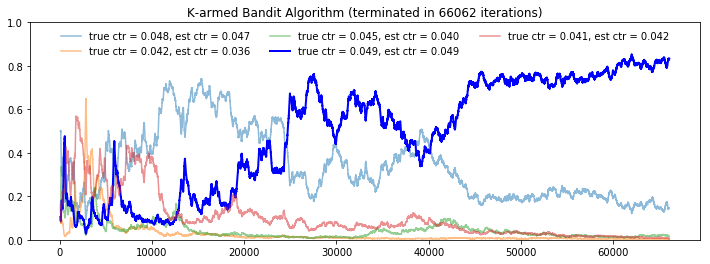

In [17]:
plot_history(ctrs, est_ctrs, history_p, 
             title="K-armed Bandit Algorithm (terminated in %i iterations)"%sum(traffic), rolling=100)